# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings

from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generate Data

First, let's generate some unlabelled data:


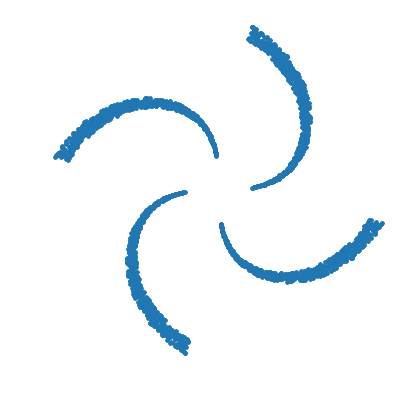

In [2]:
dataset = 2
dimensions = 2

# Dataset 1: Random Points
if dataset == 1:
    nclusters = 4
    covariance = 2
    npoints = 1200
    minRange = 0
    maxRange = 100

    dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                          labelled=False, random_flip=True, nonlinearities=True)

    if dimensions == 2:
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(8,6)
        plot_data(dataset, "Unlabelled data", ax, labels=False, minrange=minRange, maxrange=maxRange, margin=30)
        plt.savefig("../Figures/density_tree/unlabelled-data.pdf", bbox_inches='tight', pad_inches=0)

        plt.show()

# Dataset 2: Fermat Spiral        
elif dataset==2:
    n_points = 600
    theta = np.linspace(np.pi/50,7*np.pi/16,n_points)
    divergence = 0.05
    a = np.random.uniform(1-divergence,1+divergence,n_points)

    x = a*np.sqrt(theta)*np.cos(theta)
    y = a*np.sqrt(theta)*np.sin(theta)

    n_spirals = 4
    for i in range(1,5):
        x_, y_ = rotate([0,0],[x,y],i*2*np.pi/n_spirals)
        x = np.concatenate((x,x_))
        y = np.concatenate((y,y_))

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.scatter(x,y, marker='.')
    plt.savefig("../Figures/density_tree/unlabelled-data-spiral.pdf", bbox_inches='tight')
    
    # save as new dataset
    dataset = np.asarray([x,y]).T
    minRange = np.min(x)
    maxRange = np.max(x)
    
# Dataset 3: S-shape
elif dataset==3:
    n_points = 300
    theta = np.linspace(np.pi/4,6*np.pi/4,n_points)
    divergence = 0.05
    a = np.random.uniform(1-divergence,1+divergence,n_points)

    x = a*np.sqrt(theta)*np.sin(theta)
    y = a*np.sqrt(theta)*np.cos(theta)*x


    fig = plt.figure(figsize=(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.scatter(x,y, marker='.')
    plt.savefig("../Figures/density_tree/unlabelled-data-spiral.pdf", bbox_inches='tight')
    
    # save as new dataset
    dataset = np.asarray([x,y]).T
    minRange = np.min([np.min(x),np.min(y)])
    maxRange = np.max([np.max(x),np.max(y)])

In [3]:
"""from ipywidgets import interact, FloatSlider
def fig(begin, end):
    ind = np.arange(begin,end)
    plt.scatter(dataset[ind,0],dataset[ind,1])
    plt.title("Entropy: %.3f" % entropy_gaussian(dataset[ind]))

interact(fig,begin=(0,len(dataset),20),end=(0,len(dataset),50))
"""

'from ipywidgets import interact, FloatSlider\ndef fig(begin, end):\n    ind = np.arange(begin,end)\n    plt.scatter(dataset[ind,0],dataset[ind,1])\n    plt.title("Entropy: %.3f" % entropy_gaussian(dataset[ind]))\n\ninteract(fig,begin=(0,len(dataset),20),end=(0,len(dataset),50))\n'

#### Create single Density Tree

In [4]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

def plot_clusters_node(node, side):
    if side == 'l' or side is None:
        subset_dataset = node.get_dataset('l',dataset)
        plt.scatter(subset_dataset[:,0],subset_dataset[:,1])
    if side == 'r' or side is None:
        subset_dataset = node.get_dataset('r',dataset)
        plt.scatter(subset_dataset[:,0],subset_dataset[:,1])


    if node.parent is not None:
        if node.parent.left == node:
            plot_clusters_node(node.parent, 'r')
        else:
            plot_clusters_node(node.parent, 'l')
            
def plot_splits(dataset, root):
    cut_vals, cut_dims = get_values_preorder(root, [], [])
    cut_vals = np.asarray(cut_vals).astype(float)
    cut_dims = np.asarray(cut_dims).astype(int)

    # show splits
    x_split = cut_vals[cut_dims == 0]
    y_split = cut_vals[cut_dims == 1]
    
    fig, ax = plt.subplots(1, 1, figsize=(7,7))
    plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split,
              minrange=minRange, maxrange=maxRange, margin=.3)

    %clear
    plt.axis('off')
    plt.show()

    
def plot_ellipses(dataset, root):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,8)
    plot_data(draw_subsamples(dataset,.05), "Unlabelled data", ax, labels=False, n_clusters=5, covs=covs, means=means,
              minrange = minRange, maxrange = maxRange, margin=.3)
    plt.savefig("../Figures/density_tree/unlabelled-data-cov.pdf", bbox_inches='tight', pad_inches=5)
    plt.axis('off')
    plt.show()

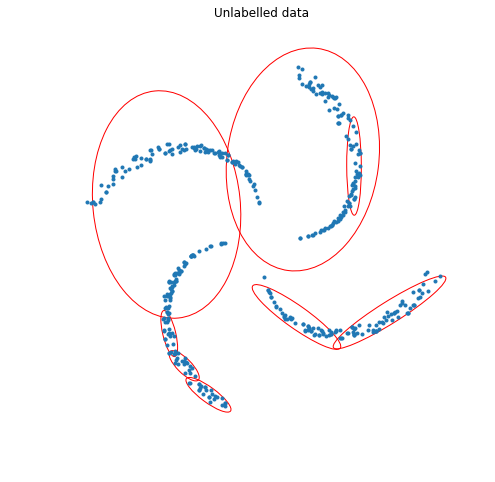

In [5]:
warnings.filterwarnings("ignore")
max_depth = 2
fact_improvement = 1
min_subset = 0.05

root = create_density_tree(dataset, max_depth=max_depth, min_subset=min_subset, n_max_dim=2, 
                           verbose=False, fact_improvement=fact_improvement)
covs, means = get_clusters(root, [], [])    

# showing covariance ellipses around clusters
plot_ellipses(dataset, root)

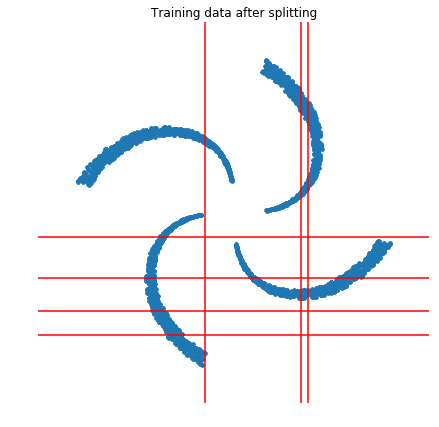

In [6]:
plot_splits(dataset, root)

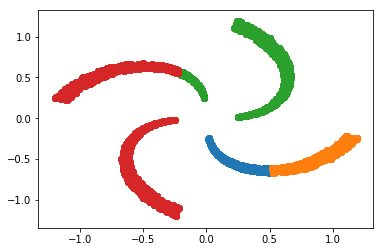

In [7]:
plot_clusters_node(root.right.left, None)

# Printing the Tree

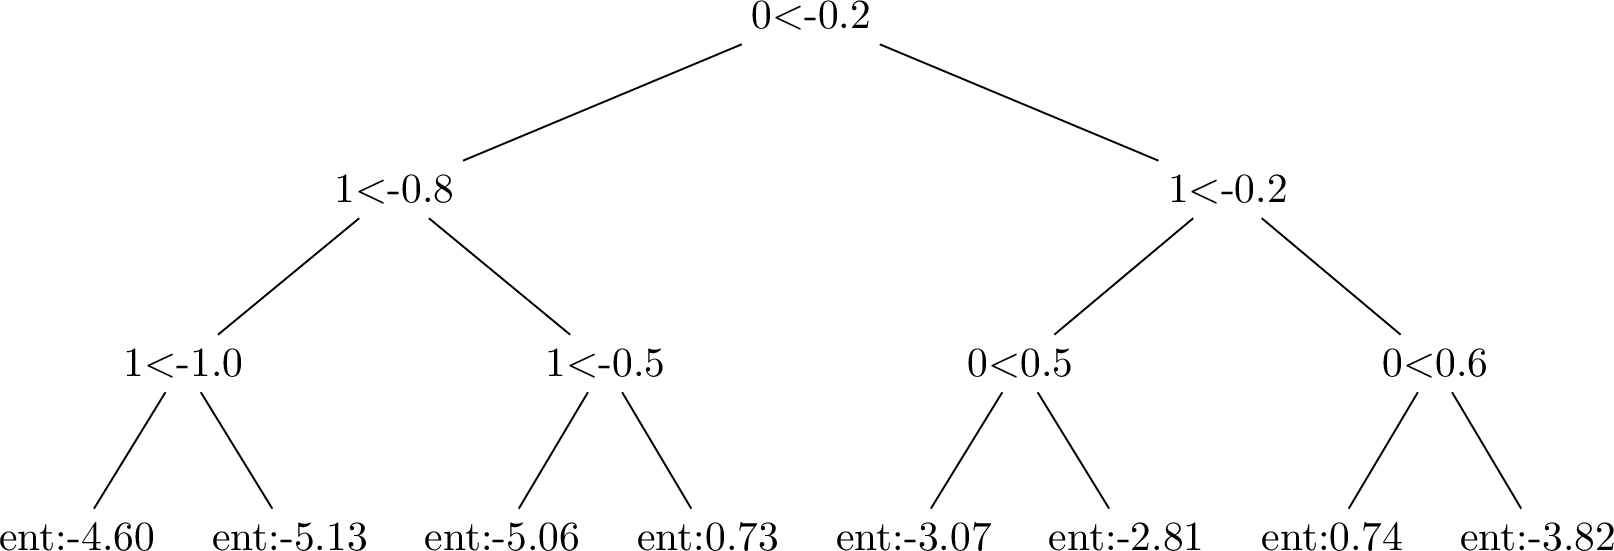

In [8]:
# ATTENTION: requires LaTeX, imagemagick to be installed

def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    cdir = "cd ../Figures/density_tree;"
    
    os.system(cdir + "rm density-tree.tex")
    os.system(cdir + "more main_pt1.tex >> density-tree.tex; echo '' >> density-tree.tex;")
    os.system(cdir + "echo '" + tree_string + "' >> density-tree.tex;  more main_pt2.tex >> density-tree.tex;")
    os.system(cdir + "/Library/TeX/texbin/pdflatex density-tree.tex")
    os.system(cdir + "convert -density 300 -trim density-tree.pdf -quality 100 density-tree.png")
    os.system(cdir + "rm *.aux *.log")
    display(Image('../Figures/density_tree/density-tree.png', retina=True))
    
tree_visualize(root)

In [9]:
from scipy.stats import multivariate_normal

# loop
def create_plot_surface(minRange, maxRange, roots, n_points_dim=100, standardize=False, thresh=.01):
    """thresh: pct of data in each leaf node"""
    grid = np.linspace(minRange, maxRange, n_points_dim)
    probas_out = np.zeros((n_points_dim,n_points_dim))

    
    for idx_x, pt in tqdm(enumerate(grid)):
        for idx_y, g in enumerate(grid):
            proba_pt=[]
            for root in roots:
                # descend tree
                d_mean, d_cov, d_pct, d_pdf_mean = descend_density_tree([pt, g], root)
                # probability for this point to be from this distribution
                if d_pct>thresh:
                    try:
                        mn = multivariate_normal.pdf([pt, g], d_mean, d_cov) 
                        if standardize: 
                            mn /= d_pdf_mean
                        proba_pt.append(mn)
                    except:
                        proba_pt.append(np.nan)

                
            probas_out[idx_x, idx_y] = np.nanmean(proba_pt)

    return probas_out
    fig = plt.figure(figsize=(7,7))
    plt.imshow(probas_out)

100it [00:01, 53.92it/s]


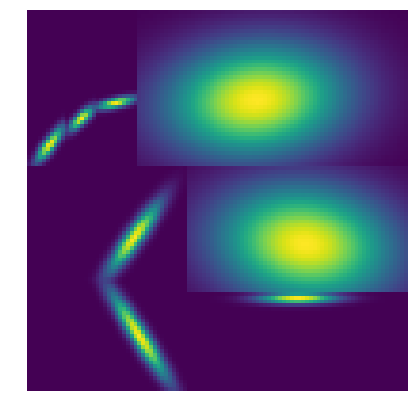

In [10]:
probas = create_plot_surface(minRange, maxRange, [root], n_points_dim=100, standardize=True, thresh=0)
fig = plt.figure(figsize=(7,7))
plt.imshow(probas)
plt.axis('off')
plt.show()
#plt.savefig("../Figures/density_tree/spirals_one_tree_maxDepth"+str(max_depth)+".pdf", bbox_inches='tight', pad_inches=0)

#### Descend tree (predict "label")

In [12]:
# for all points 
probas = []
probas_other = []
for d in dataset:
    # descend tree
    d_mean, d_cov, d_pct, d_pdf_mean = descend_density_tree(d,root)

    # probability for this point to be from this distribution
    probas.append(my_normal(d, d_mean, d_cov) / my_normal(d_mean,d_mean,d_cov))
    for i in range(n_spirals):
        probas_other.append(my_normal(d, means[i], covs[i])*d_pct)
    
print("Probability to come from the leaf node cluster: %.5f%%" % np.mean(probas))
print("Probability to come from an arbitrary cluster: %.5f%%" % np.mean(probas_other))

Probability to come from the leaf node cluster: 0.42828%
Probability to come from an arbitrary cluster: 0.08280%


#### Density Forest

In [13]:
n_trees = 30
subsample_pct = .05

root_nodes = density_forest_create(dataset, max_depth=max_depth, min_subset=min_subset, 
                                   n_trees=n_trees, subsample_pct=subsample_pct, n_max_dim=2, 
                                   n_jobs=-1, fact_improvement=fact_improvement)

[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    1.3s finished


In [14]:
root_nodes = np.asarray(root_nodes)
root_nodes = root_nodes[np.not_equal(root_nodes, None)]

In [15]:
probas = create_plot_surface(minRange, maxRange, root_nodes, n_points_dim=100, standardize=False, thresh=.04)

100it [00:32,  3.09it/s]


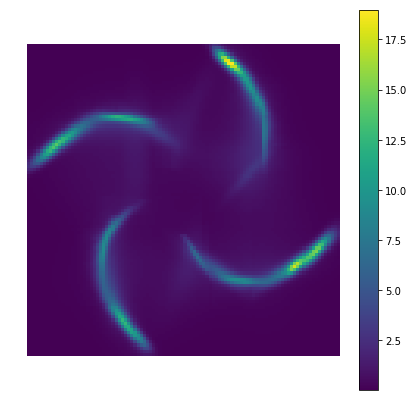

In [16]:
fig = plt.figure(figsize=(7,7))
plt.imshow(probas) 
plt.axis('off')
plt.savefig("../Figures/density_tree/spirals_forest_maxDepth"+str(max_depth)+"_nTrees"+str(n_trees)+"_pct"+str(subsample_pct)+".pdf", bbox_inches='tight', pad_inches=0)
plt.colorbar()

In [17]:
probas = create_plot_surface(minRange, maxRange, root_nodes, n_points_dim=100, standardize=True, thresh=.04)

100it [00:32,  3.12it/s]


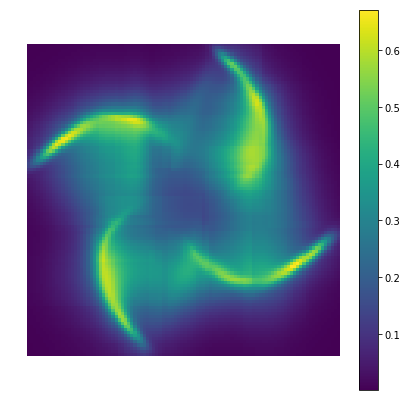

In [18]:
fig = plt.figure(figsize=(7,7))
plt.imshow(probas)
plt.axis('off')
plt.savefig("../Figures/density_tree/spirals_forest_maxDepth"+str(max_depth)+"_nTrees"+str(n_trees)+"_pct"+str(subsample_pct)+".pdf", bbox_inches='tight', pad_inches=0)
plt.colorbar()